In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import numpy.linalg as npl
import scipy.io as spio
from scipy import interpolate
import mat73
import os
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image
import pandas as pd
import csv

import toolbox.tools_signal as ts
import toolbox.geodesic as tg


import ot
import ot.plot

# Mesure de Similarité dans le cas des Séries Temporelles

## Importation des données

In [106]:
## Ici, je charge directement les données .mat
# name = 'CHLAOC5' #ou 
# name = 'SPM_BingHan'
def LoadData(name,station,mod='X',res='small'):
    # LoadData takes a repertory name, station number and module X,T,S,I and a resolution
    # returns :   S the lxLxT matrix of the recorded values at every point and every acquisiton time of the map
#                 pos_ref the x,y position of the reference station
    data_path = os.getcwd()+'\DATA'
    filename = data_path+'\\'+name+'_'+res+'\Somlit_'+str(station)+'_'+name+'_'+mod+'.mat'
    if name=='CHLAOC5':
        mat = spio.loadmat(filename)
    elif name=='SPM_BingHan':
        mat = mat73.loadmat(filename)
    S = mat[[*mat][-1]]    
    refs_filename = data_path+'\\'+name+'_'+res+'\\ref_station.csv'
    refs = np.loadtxt(refs_filename,delimiter=',',dtype='int')
    pos_ref = refs[np.where(refs[:,0]==station),1:][0,0]
    return S, pos_ref

def ExtractSignal(S,x,y,interpolation='True'):
    n,m,T=np.shape(S)
    s = np.copy(S[x,y,:])
    t = (~np.isnan(s)).nonzero()
    t = np.reshape(t,np.shape(s[t]))
    # On effectue un traitement qui permet de "combler les trous" pour les signaux ayant un certain nombre de NaN 
    # et supprimer ceux en ayant trop
    if np.count_nonzero(np.isnan(s))!=0 and interpolation:
        if np.count_nonzero(np.isnan(s))>=T/2:
            s[:] = np.nan
            t = (~np.isnan(s)).nonzero()
            t = np.reshape(t,np.shape(s[t]))
        else:
            fs = interpolate.interp1d(t,s[t])         # On interpole les valeurs qu'on sait être non NaN
            s = fs(np.arange(t[0],t[-1]+1))                 # puis on reconstruit le signal jusqu'au maximum (dernier t non Nan)
    return s,t                                        # On renvoit le signal reconstruit et les indices non NaN

def InterpolateAllSignal(S):
    n,m,T=np.shape(S)
    Stemp = np.empty(np.shape(S))
    Stemp[:] = np.nan 
    Tmaxs = []
    Tmins = []
    for i in range(n):
        for j in range(m):
            s,t = ExtractSignal(S,i,j)
            if len(t)!=0:
                Stemp[i,j,t[0]:t[-1]+1] = s
                Tmaxs += [t[-1]+1]
                Tmins += [t[0]]
    Tmax = min(Tmaxs)
    Tmin = max(Tmins)
    Sinter = Stemp[:,:,Tmin:Tmax]
    return Sinter

# Choix de la station 
revenir ici pour changer les valeurs

In [174]:
# name = 'CHLAOC5' #ou 
name = 'SPM_BingHan'
station=10
mod='X'
res='big'
x,y = [130,30]
S,pos=LoadData(name,station,mod,res)
Si = InterpolateAllSignal(S)

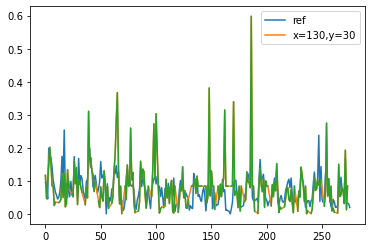

In [175]:
s,_ = ExtractSignal(S,x,y,False)
sp,_ = ExtractSignal(S,x,y) 
s_ref, _=ExtractSignal(S,pos[0],pos[1])
plt.figure()
# plt.plot(frequencies,psd,'r',frequencies,psd_ref,'b')
plt.plot(s_ref,label='ref')
plt.plot(sp,label='x=%i,y=%i'%(x,y))
plt.plot(s)
plt.legend()

## Affichage des données sur la carte

On affiche la moyenne de la série temporelle brute pour chaque point de la carte, plus la station de référence.

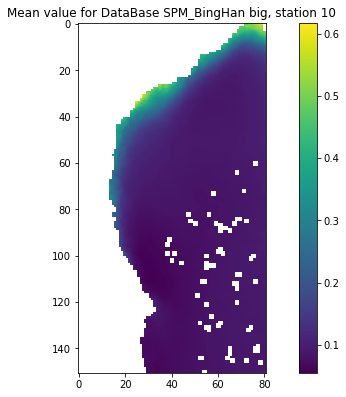

In [176]:
n,m,T = np.shape(Si)
imMean = np.zeros((n,m))
for i in range(n):
    for j in range(m):
        imMean[i,j] = np.mean(Si[i,j,:])

plt.figure(figsize=(12,m/n*12))
plt.imshow(imMean)
plt.colorbar()
plt.title('Mean value for DataBase %s %s, station %i' %(name,res,station))
plt.show()

__Affichage dynamique en temps__
A revoir parce que là c'est bancal

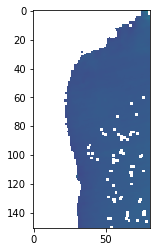

In [177]:
import animatplot as amp

def DataToGIF(name,station,mod='X',res='small'):
    S,ref = LoadData(name,station,mod,res)
    gifname = name+'_'+res+'_'+str(station)+'_'+mod
    images = []
    T = np.shape(S)[-1]
    for t in range(T):
        images.append(S[:,:,t])
    block = amp.blocks.Imshow(images)
    gif = amp.Animation([block])
#     gif.controls()
    gif.save_gif(gifname)
    return gifname+'.gif'

Image(url=DataToGIF(name,station,mod,res))

## Test sur les NPSD

True
False


D:\applications\Anaconda\lib\site-packages\numpy\lib\function_base.py:1535: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi


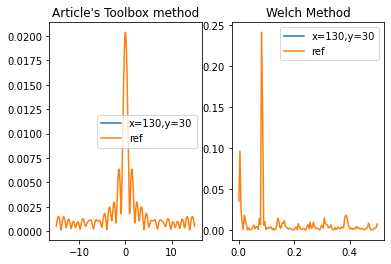

In [178]:
print(np.any(np.isnan(s)))
print(np.any(np.isnan(s_ref)))
###########Avec la toolbox proposée
times = np.linspace(0,1,len(s)-1)
n = 501
frequencies = np.linspace(-15,15,n)


psd     = ts.Signal2NPSD(frequencies,times,s)
psd_ref = ts.Signal2NPSD(frequencies,times,s_ref)
phase1 = np.unwrap(np.angle(ts.fourierTransform(frequencies,times,s)))
phase2 = np.unwrap(np.angle(ts.fourierTransform(frequencies,times,s_ref)))

############Avec la librairie scipy, méthode Welch
import scipy.signal as sps
wf, wpsd    = sps.welch(s)
wf_ref, wpsd_ref = sps.welch(s_ref)
wpsd /= np.sum(wpsd)
wpsd_ref /= np.sum(wpsd_ref)


fig,ax = plt.subplots(1,2)
ax[0].plot(frequencies,psd,label='x=%i,y=%i'%(x,y))
ax[0].plot(frequencies,psd_ref,label='ref')
ax[0].set_title('Article\'s Toolbox method')
ax[0].legend()
ax[1].plot(wf,wpsd, label='x=%i,y=%i'%(x,y))
ax[1].plot(wf_ref,wpsd_ref, label='ref')
ax[1].set_title('Welch Method')
ax[1].legend()
plt.show()

## Extraire toutes les NPSD de l'image

Pas sûre que ça soit possible

In [179]:

def PSDImage(S,freq):
    """
    Given an "image" computes the PSD for each of its pixel/time series

    Parameters
    ----------
    S           : the 'image'
    frequencies : array of frequencies on which to compute the NPSD
    
    Returns
    -------
    psd
    freq   : array of sample frequencies
    """
    n,m,T = np.shape(S)
    PSD = np.zeros((n,m,len(freq)))
    times = np.linspace(0,1,T)
    for x in range(n):
        for y in range(m):
            s = S[x,y,:]
            if not(np.any(np.isnan(s))):
                PSD[x,y,:] = ts.Signal2PSD(freq,times,s)
            else:
                PSD[x,y,:] = np.nan
    return PSD

In [180]:
n=301
freq = np.linspace(-15,15,n)
PSD = PSDImage(Si,freq)
psd = PSD[x,y,:]
psd_ref = PSD[pos[0],pos[1]]

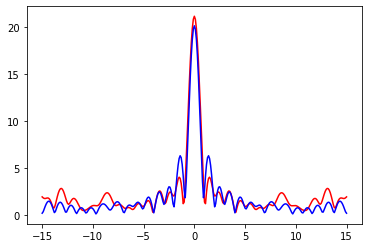

In [181]:
plt.figure()
plt.plot(freq,psd,'r')
plt.plot(freq,psd_ref,'b')

## Cost Matrix between the frequencies

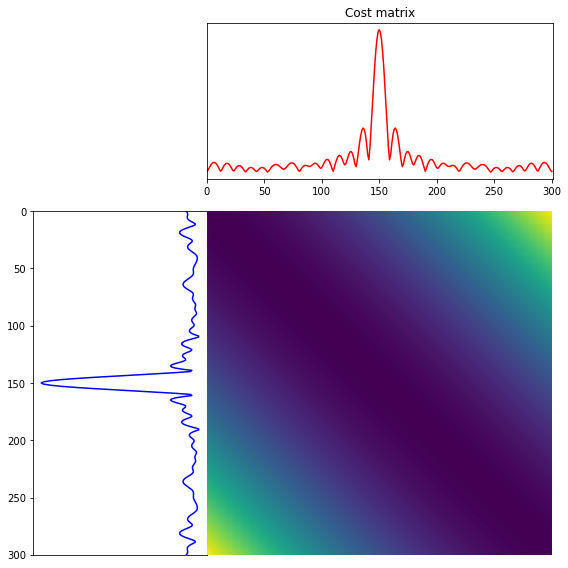

In [182]:
# a,b are 1D histograms (sum to 1 and positive)
# M is the ground cost matrix
M = ot.dist(freq.reshape((n,1)),freq.reshape((n,1)))
M /= M.max()
plt.figure(figsize=(8,8))
ot.plot.plot1D_mat(psd,psd_ref,M,'Cost matrix')

## Solve EMD + Wasserstein Distance

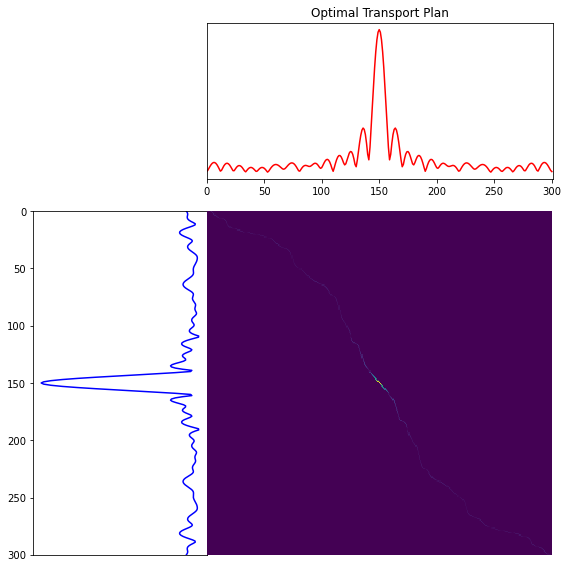

Wasserstein distance w\o regulation =  0.00350086359453245


In [183]:
#plan de transport optimal
npsd = psd/np.sum(psd)
npsd_ref = psd_ref/np.sum(psd_ref)
T0 = ot.emd(npsd,npsd_ref,M)
plt.figure(figsize=(8,8))
ot.plot.plot1D_mat(npsd,npsd_ref,T0,'Optimal Transport Plan')
plt.show()
W1 = ot.emd2(npsd,npsd_ref,M)
print('Wasserstein distance w\o regulation = ', W1)

## Distance de Wasserstein entre les npsd de l'image

In [184]:
def WassersteinNPSD(S,ref,freq,mu=0):
    PSD = PSDImage(S,freq)
    n,m,F = np.shape(PSD)
    psd_ref = PSD[ref[0],ref[1],:]
    norm_psd_ref = np.sum(psd_ref)
    npsd_ref = psd_ref/norm_psd_ref
        
    M = ot.dist(freq.reshape((F,1)),freq.reshape((F,1)))
    M /= M.max()
    
    WImage = np.zeros((n,m))
    for x in range(n):
        for y in range(m):
            if not(np.any(np.isnan(PSD[x,y]))):
                psd = PSD[x,y]
                norm_psd = np.sum(psd)
                npsd = psd/norm_psd
                WImage[x,y] = ot.emd2(npsd,npsd_ref,M) + mu*np.abs(norm_psd-norm_psd_ref)
            else :
                WImage[x,y] = np.nan
    return WImage, M

In [185]:
n=301
freq = np.linspace(-15,15,n)

In [194]:
W,M = WassersteinNPSD(Si,pos,freq,2e-6)

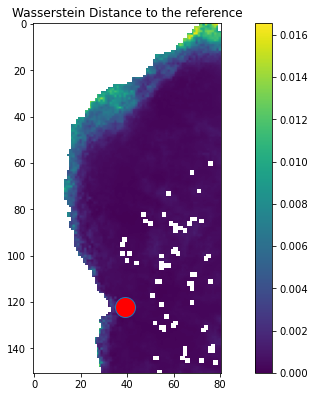

Text(0, 0.5, 'Wasserstein Distance')

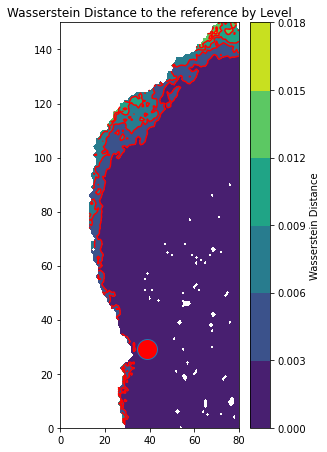

In [195]:
n,m = np.shape(W)
plt.figure(figsize=(12,m/n*12))
plt.imshow(W)
plt.plot(pos[1],pos[0], marker="o", markersize=20, markerfacecolor='r')
plt.title('Wasserstein Distance to the reference')
plt.colorbar()
plt.show()

fig,ax = plt.subplots(figsize=(4,4*n/m))
CF = ax.contourf(W[::-1,:],levels=5)
CNF = ax.contour(CF, levels=CF.levels, colors='r')
ax.set_title('Wasserstein Distance to the reference by Level')
ax.plot(pos[1],n-pos[0], marker="o", markersize=20, markerfacecolor='r')
cbar = fig.colorbar(CF)
cbar.ax.set_ylabel('Wasserstein Distance')